In [39]:
import random
import numpy as np
import pandas as pd
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.cm as cm
import seaborn as sns

from scipy import stats
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [462]:
# Weekly data
df= pd.read_csv("/Users/choejunhoe/Desktop/Personal Projects/MSCI_analysis/MSCI_cluster.csv",index_col='date').dropna()

In [464]:
msci= df.iloc[:,0].to_frame("MSCI ACWI")
msci

,MSCI ACWI
date,
1995-12-29,181.895
1996-01-05,184.457
1996-01-12,181.085
1996-01-19,181.998
1996-01-26,182.394
...,...
2024-12-06,873.726
2024-12-13,866.140
2024-12-20,844.228


In [465]:
return_msci = msci.pct_change().dropna()
return_msci.head()

,MSCI ACWI
date,
1996-01-05,0.014085
1996-01-12,-0.018281
1996-01-19,0.005042
1996-01-26,0.002176
1996-02-02,0.022013


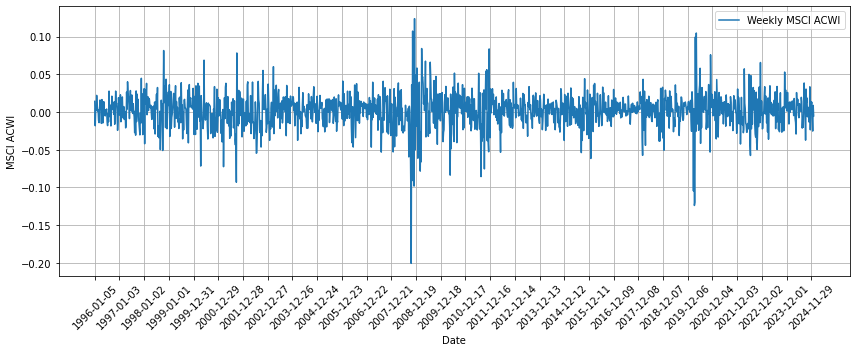

In [38]:
plt.figure(figsize=(12, 5))
plt.plot(return_msci.index,return_msci,label='Weekly MSCI ACWI')
plt.ylabel('MSCI ACWI')
plt.xlabel('Date')

plt.legend()
plt.xticks(return_msci.index[::52], rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


Above graph shows that volatility clusters; hence, we will use GARCH(1,1) model to obtain volatility.

I will first estimate first 500 period's conditional variance; $h_t$. Then, I will use 1-step ahead forecast for later $h_t$ which is OOS(Out of Sample). \
The reason I do this instead of just let the vol = in-sample conditional volatility is as follows.
* The in-sample conditional volatility is made with [$r_0$,$r_{t}$]. So, $\sigma_{t-1}$ is estimated using $r_t$.\
     In other words, information of $r_t$ is in $\sigma_{i : i<t}$. 
* The OOS is different. $\sigma_{t}$ is generated by fitting a GARCH Model only using data upto t-1.
     1. Forecasting the conditional variance (1-step ahead forecast): $h_t = \mathbb{E}\left[ r_t^2 \mid \mathcal{F}_{t-1} \right]$\
     
     2. Taking $\sigma_t = \sqrt{h_t}$


Therefore, if you want to see volatility itself, in-sample is great measure. However, what we want is GMM clustering.\
The variables that I am going to use are
* $z_t = r_t/\sigma_t$
* $\sigma_t$

For In-sample,  $\sigma_t$ <- $\sigma_{t-1}^{In-Sample}$.\
For OOS, $\sigma_t$  <- $\sigma_{t-1}^{OOS}$

In-sample may generate look-ahead bias.
* In-sample volatility often looks smoother and better-fitted, because it’s optimized with future returns.
* However, this optimization introduces information leakage:
    * $z_t$ may correlate with $\sigma_{t-1}^{In-Sample}$, reducing clarity of GMM separation.
* GMM may misinterpret the entangled structure and assign regimes incorrectly.

OOS is more plausible because
* Use only past info
* orthogonal to $r_t$
* No look-ahead Bias




In [104]:
# Fit GARCH(1,1) (in-sample) & Forecast one-step-ahead h_t (Expending refit(Expanding Window Forecast))
# Very time-consuming

min_train = 500
T= len(return_msci)
r=return_msci['MSCI ACWI']

h = pd.Series(index=return_msci.index, dtype=float)

# For first 500 periods(Training period), use In-sample conditional vol
res0= arch_model(r.iloc[:min_train]*100
                    ,vol='GARCH', dist='t', p=1,q=1,mean='Zero').fit(disp='off')

h.iloc[:min_train] = (res0.conditional_volatility.values/100)**2

# For later period, use OOS forecast for each sigma_{i:i>=min_train}
# 1 step ahead forecast
for t in range(min_train-1, T-1):
    r_sub = r.iloc[:t+1]  # [0 .. t-1]
    res = arch_model(r_sub*100, vol='GARCH', p=1, q=1, mean='Zero', dist='t').fit(disp='off')

    f = res.forecast(horizon=1, align='origin')
    # h_t is Conditional Variance of r_{t+1} which is forecasted at period t. 
    # so, match the index
    h.iloc[t+1] = f.variance.iloc[-1, 0] / (100.0**2)

sigma = h.pow(0.5)
z = r / sigma

Now, I will use GMM to get clusters. 
* Use $z_t = r_t/\sigma_t$ and $\log(\sigma_t)$

In [43]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [139]:
# Choose number of clusters

def choose_k_with_bic(X, k_min=2, k_max=8):
    out = []
    for k in range(k_min, k_max+1):
        gmm = GaussianMixture(  n_components=k, 
                                covariance_type='full', 
                                random_state=42, 
                                n_init=5                # 내부적으로 알고리즘을 5번 서로다른 초기값으로 돌려서 가장 높은 log-likelihood 선택
                                ).fit(X)
        out.append((k, gmm.bic(X), gmm.aic(X)))
    return pd.DataFrame(out, columns=['k','BIC','AIC']).set_index('k')

In [248]:
X = np.column_stack([return_msci, np.log(sigma)])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [249]:
components_df= choose_k_with_bic(X_scaled)
best_k_bic = components_df['BIC'].idxmin()
best_k_aic = components_df['AIC'].idxmin()

print("Best k (BIC) is",best_k_bic)
print("Best k (AIC) is",best_k_aic)
print(components_df)

Best k (BIC) is 3
Best k (AIC) is 4
           BIC          AIC
k                          
2  7972.424175  7913.876560
3  7958.356464  7867.873786
4  7961.342262  7838.924522
5  8002.535347  7848.182544
6  8043.672454  7857.384589
7  8078.708494  7860.485566
8  8091.468345  7841.310355


### I will use k=6 to see world economic states.

In [250]:
gmm_6 = GaussianMixture(  n_components=6, 
                                covariance_type='full', 
                                random_state=42, 
                                n_init=5               
                                ).fit(X_scaled)

clusters = gmm_6.fit_predict(X)


In [251]:
msci_awci= pd.DataFrame({
                            'MSCI ACWI': msci[1:]['MSCI ACWI'],
                            'return' : return_msci['MSCI ACWI'],
                            'volatility': sigma,
                            'z_t': z,
                            'cluster': clusters
})


In [252]:
msci_awci

,MSCI ACWI,return,volatility,z_t,cluster
date,,,,,
1996-01-05,184.457,0.014085,0.012184,1.156043,4
1996-01-12,181.085,-0.018281,0.012387,-1.475751,4
1996-01-19,181.998,0.005042,0.012775,0.394665,4
1996-01-26,182.394,0.002176,0.012695,0.171400,4
1996-02-02,186.409,0.022013,0.012587,1.748814,4
...,...,...,...,...,...
2024-12-06,873.726,0.013029,0.019493,0.668382,0
2024-12-13,866.140,-0.008682,0.018917,-0.458971,0
2024-12-20,844.228,-0.025298,0.018079,-1.399309,0


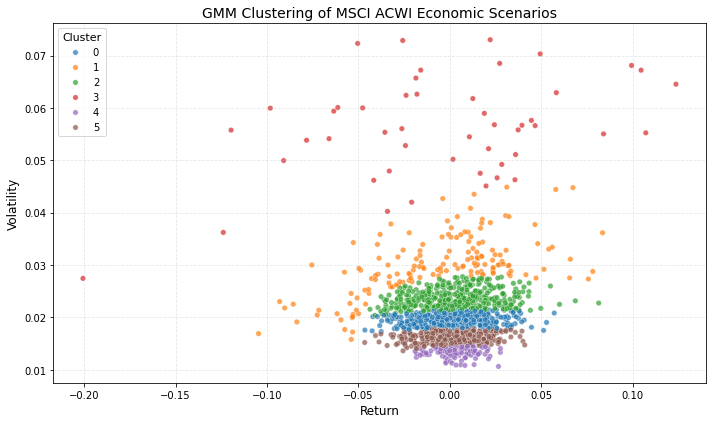

In [253]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=msci_awci,
                x='return',y='volatility',
                hue='cluster',
                palette='tab10',
                s=30,  # 점 크기
                alpha=0.7
                )
plt.title('GMM Clustering of MSCI ACWI Economic Scenarios', fontsize=14)
plt.xlabel('Return', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(title='Cluster', title_fontsize=11, fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


* Cluster 0: Around zero Return, Low Volatility
    * Neutral Stable
* Cluster 1: Negative Return, Moderate Volatility
    * Mild Recession
* Cluster 2: Positive Return, Moderater Volatility
    * Expension
* Cluster 3: Extreme Negative or Positive Return, High Volatility
    * Crisis
* Cluster 4: Close to zero or slightly Negative Return, Extremely low Volatility
    * Deflationary Trap / Stagnation
* Cluster 5: Mild Postive Return, Lowest Volatility
    * Post-Policy Calm / Stabilization Phase


In [303]:
def cluster_transition_m(df):
    # Empty transition matrix
    P = np.zeros((6, 6))  
    
    # Loop for all elements in cluster columns.
    for i in range(len(df) - 1):
        curr = int(df['cluster'].iloc[i])
        next_ = int(df['cluster'].iloc[i + 1])
        
        # Only count transitions
        if curr!= next_:
            P[curr][next_] += 1

    # unit to percentage
    for k in range(6):
        row_sum = P[k].sum()
        if row_sum>0:
            P[k] /= row_sum  

    return P

def cluster_stay_transition_m(df):
    # Empty transition matrix
    P = np.zeros((6, 6))  
    
    # Loop for all elements in cluster columns.
    for i in range(len(df) - 1):
        curr = int(df['cluster'].iloc[i])
        next_ = int(df['cluster'].iloc[i + 1])
        P[curr][next_] += 1

    # unit to percentage
    for k in range(6):
        row_sum = P[k].sum()
        if row_sum>0:
            P[k] /= row_sum  

    return P



In [307]:
cluster_stay_transition_m(msci_awci)

array([[0.849246, 0.017588, 0.062814, 0.000000, 0.000000, 0.070352],
       [0.006494, 0.766234, 0.194805, 0.032468, 0.000000, 0.000000],
       [0.087282, 0.049875, 0.862843, 0.000000, 0.000000, 0.000000],
       [0.000000, 0.104167, 0.000000, 0.895833, 0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000000, 0.921053, 0.078947],
       [0.062814, 0.010050, 0.000000, 0.000000, 0.020101, 0.907035]])

In [316]:
P_transition_only= cluster_transition_m(msci_awci)
P_transition_only

array([[0.000000, 0.116667, 0.416667, 0.000000, 0.000000, 0.466667],
       [0.027778, 0.000000, 0.833333, 0.138889, 0.000000, 0.000000],
       [0.636364, 0.363636, 0.000000, 0.000000, 0.000000, 0.000000],
       [0.000000, 1.000000, 0.000000, 0.000000, 0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 1.000000],
       [0.675676, 0.108108, 0.000000, 0.000000, 0.216216, 0.000000]])

This is plusible results.

* From Cluster 0: Neutral Stable
    * Expansion (2): 41.7%
    * Post-policy calm (5): 46.7%
    * Mild recession (1): 11.7%\
The market, when in a neutral and stable state, tends to transition into either a growth phase (Expansion) or a low-risk policy-stabilized phase. Occasionally, it slips into mild recession. This reflects a market at a turning point, sensitive to new signals.

* From Cluster 1: Mild Recession
    * Expansion (2): 83.3%
    * Crisis (3): 13.9%
    * Neutral Stable (0): 2.8%\
A mild recession typically leads to recovery and expansion. Occasionally, it worsens into a crisis, and rarely does it stabilize directly into neutrality.

* From Cluster 2: Expansion
    * Neutral Stable (0): 63.6%
    * Mild Recession (1): 36.4%\
The expansion phase tends to return to neutrality or fall back into recession. Interestingly, there is no direct transition to Crisis, suggesting either a structural robustness or a potential blind spot in early warning detection.

* From Cluster 3: Crisis
    * Mild Recession (1): 100%\
Every time the market exits a crisis, it reverts to a mild recession — not a full recovery. This is highly plausible, reflecting the real-world tendency for markets to gradually normalize after shocks rather than bounce directly back into expansion.

* From Cluster 4: Deflationary Trap / Stagnation
    * Post-policy Calm (5): 100%\
When the market exits a deflationary or ultra-low-volatility trap, it always moves into a post-policy stabilization regime. This suggests policy intervention is effective at nudging the market into a calmer state: a common macroeconomic narrative.

* From Cluster 5: Post-policy Calm / Stabilization
    * Neutral Stable (0): 67.6%
    * Deflation/Stagnation (4): 21.6%
    * Mild Recession (1): 10.8%\
When the market exits the post-policy calm, it typically reverts to a neutral phase. Some transitions also point to a return to deflation or a slide into recession, indicating that policy calm doesn’t guarantee long-term stability.


### Calculate Mean and Standard Deviation of "Duration of each clusters"

In [321]:
from collections import defaultdict

def count_duration(df):
    staying_periods= defaultdict(list)
    duration = 1

    for i in range(1,len(df)):
        
            if df['cluster'][i-1] == df['cluster'][i]:
                    duration += 1
                
            else:
                cluster = df['cluster'][i-1]
                staying_periods[cluster].append(duration)
                duration=1

    cluster=df['cluster'].iloc[-1]
    staying_periods[cluster].append(duration)

    staying_df=pd.DataFrame.from_dict(staying_periods,orient='index').T

    staying_df.columns= [f"Cluster_{col}" for col in staying_df.columns]
    return staying_df


def mean_std_duration_daily(staying_df):
    mean_variance =[]
    for cluster, stay in staying_df.items():
        # Convert from Weekly basis to Daily basis
        mean= np.mean(stay)*7
        std= np.std(stay)*7
        mean_variance.append((cluster,mean,std))

    return pd.DataFrame(mean_variance, columns=['Clusters', 'Mean',"Standard Deviation"]).sort_values('Clusters').set_index('Clusters')


In [329]:
duration_weekly=count_duration(msci_awci)
duration_weekly

/var/folders/mc/mbs2vjqs7dzfpxw7nnj54t440000gn/T/ipykernel_37519/2227115260.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['cluster'][i-1] == df['cluster'][i]:
/var/folders/mc/mbs2vjqs7dzfpxw7nnj54t440000gn/T/ipykernel_37519/2227115260.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster = df['cluster'][i-1]


,Cluster_4,Cluster_5,Cluster_0,Cluster_2,Cluster_1,Cluster_3
0,45.0,43.0,1.0,1.0,1.0,30.0
1,1.0,1.0,1.0,5.0,1.0,2.0
2,1.0,1.0,1.0,4.0,1.0,1.0
3,48.0,1.0,13.0,5.0,1.0,12.0
4,6.0,2.0,1.0,2.0,1.0,3.0
...,...,...,...,...,...,...
56,NaN,NaN,4.0,NaN,NaN,NaN
57,NaN,NaN,5.0,NaN,NaN,NaN
58,NaN,NaN,3.0,NaN,NaN,NaN
59,NaN,NaN,4.0,NaN,NaN,NaN


In [337]:
duration= mean_std_duration_daily(duration_weekly)
duration

,Mean,Standard Deviation
Clusters,,
Cluster_0,45.786885,48.984814
Cluster_1,29.944444,42.821947
Cluster_2,51.036364,57.594812
Cluster_3,67.200000,76.502026
Cluster_4,88.666667,128.014756
Cluster_5,75.297297,124.726049


In [348]:
stata=3
mu,sd = duration.iloc[stata,0], duration.iloc[stata,1]

print(mu)
print(sd)
            

67.2
76.5020261169598


In [520]:
duration= mean_std_duration_daily(duration_weekly)

def change_stay(state , period):
    """
    This function is to calculation probabilities for transition from cluster 'i' to cluster 'j' where i!=j.
    We assume that the periods which denoted as "staying periods in a certain cluster" follows normal distribution.

    ==============================
    parameters
    duration: DataFrame with shape (n_clusters, 2), containing [mean, std] per cluster
    state: Cluster index
    period: How long the current cluster has lasted so far

    Returns
    z-score
    change  : P(L <= t)
    stay    : P(L > t+1 | L > t)
    """
    
    mu,sd = duration.iloc[state,0], duration.iloc[state,1]

    z_score = (period-mu)/sd
    change = stats.norm.cdf(period,mu,sd)
    stay = (1-stats.norm.cdf(period+1,mu,sd))/(1-stats.norm.cdf(period,mu,sd))
    
    return z_score, change, stay

In [515]:
total_cluster= [0,1,2,3,4,5]
P = P_transition_only

def random_transition(current):
    """

    This function is to make a random transition from cluster "i" to cluster "j".

    ==============================
    parameters
    current: Current cluster that the economy is in.
    P: Transition Only matrix
    
    """
    # Get the index of the current node
    current_ind = total_cluster.index(current)
    # Get the transition probabilities for the current node
    prob = P[current_ind]
    # Random choice based on the transition matrix
    next_cluster = random.choices(total_cluster, weights=prob, k=1)[0]

    return next_cluster

In [516]:
# Count how long the cluster is in that cluster.
last_cluster = msci_awci.iloc[-1,-1]
duration_curr = 7* duration_weekly[f'Cluster_{last_cluster}'].iloc[-1]

# Probability that the initial economic state move to the other state on period 1.
p_change=change_stay(last_cluster,duration_curr)[2]
p_change


0.41742103553333554

In [517]:
def stay_period(state):
    """
    
    This function is to generate a positive integer from a normal distribution.
    This will be used for the random staying periods in a certain cluster.
    ===================================
    Parameters:
    state: Cluster index
    duration: DataFrame with shape (n_clusters, 2), containing [mean, std] per cluster
    """

    while True:
        
        mu,sd = duration.iloc[state,0], duration.iloc[state,1]
        period = int(random.gauss(mu, sd))
        
        # the period should be positive
        if period > 0:
            return period


In [518]:
last_cluster = msci_awci.iloc[-1,-1]
duration_curr = duration_weekly[f'Cluster_{last_cluster}'].iloc[-1]
last_cluster

0

In [521]:
# First trial

random.seed(123)

last_cluster = msci_awci.iloc[-1,-1]
duration_curr = duration_weekly[f'Cluster_{last_cluster}'].iloc[-1]

# start with period 1
updated_state = [last_cluster]      # Cluster 0
updated_period = duration_curr*7      # 56 days
state = []


while True:
        
    if sum(stay[1] for stay in state) -duration_curr > 365:
        break
    
    # Probability of staying at the same economic state.
    p_stay = change_stay(updated_state[-1],updated_period)[2]

    # stay at the same state
    if random.random() < p_stay:
        updated_state.append(updated_state[-1])
        updated_period += 1

    else: 
        # Update the above economic state, staying period and probability of state convertion at the period.
        state.append([updated_state[-1],updated_period,1-p_stay])
        
        # Move to next state
        next_state= random_transition(updated_state[-1])
        updated_state.append(next_state)
        
        # randomized staying period.
        updated_period= stay_period(updated_state[-1])

# Update Last transition.
state.append([updated_state[-1],updated_period,1-p_stay])

# Case 1: If the economy stays in state 0 for a while
if state[0][1] > duration_curr:
    state[0][1] = state[0][1]-duration_curr

# Case 2: If the economic state moves to the other state at period 1
if state[0][1] == duration_curr:
    del(state[0])

print(state)


[[0, 118.0, 0.0412832891778554], [5, 95, 0.0072199409705899775], [4, 95, 0.006479535110089363], [5, 330, 0.019169228071802547], [0, 71, 0.019169228071802547]]


In [513]:
initial_convert_prob = change_stay(last_cluster,duration_curr)[1]

print("Initially, the economy of the world is at state {}, stayed for {} days and the probability of converting to other state is {:.3f}".format(last_cluster,duration_curr,initial_convert_prob))
print("")
for i in range(len(state)):
    print('Then, Economic state of the world is at {}, stayed for {} days and the probability of converting to other state is {:.2f}'.format(state[i][0],state[i][1],state[i][2]))
    print("=="*90)
    

Initially, the economy of the world is at state 0, stayed for 8.0 days and the probability of converting to other state is 0.220

Then, Economic state of the world is at 0, stayed for 118.0 days and the probability of converting to other state is 0.04
Then, Economic state of the world is at 5, stayed for 95 days and the probability of converting to other state is 0.01
Then, Economic state of the world is at 4, stayed for 95 days and the probability of converting to other state is 0.01
Then, Economic state of the world is at 5, stayed for 330 days and the probability of converting to other state is 0.02
Then, Economic state of the world is at 0, stayed for 71 days and the probability of converting to other state is 0.02


In [522]:
# Simulate 1,000 times.

random.seed(123)

# Recall in first period
last_cluster = msci_awci.iloc[-1,-1]
duration_curr = duration_weekly[f'Cluster_{last_cluster}'].iloc[-1]*7

# Build empty list for the simulations
all_iter_state = []
all_iter_period = []
all_iter_prob = []

# Simulates 1000 times
for j in range(1000):
    print(f"Iteration {j+1}")
    
    # Reset state and period for each simulation
    updated_state = [last_cluster]    # Cluster 0
    updated_period = duration_curr    # 56 days
    state = [] 

    # Store data for each iterated transitions
    current_iter_prob = []  
    current_iter_state = []  
    current_iter_period = [] 

    # Transitions of states
    while True:
        
        # If total period exceed 365 days, stop the iteration
        if sum(stay[1] for stay in state) - duration_curr > 365:
            break
        
        p_stay = change_stay(updated_state[-1],updated_period)[2]

        # Duration
        if random.random() < p_stay:
            updated_state.append(updated_state[-1])
            updated_period += 1

        else: 

            # Record the former result.
            # Update state and staying period and probability of Change.
            state.append([updated_state[-1],updated_period,1-p_stay])
            
            # Store updated period, state and convertion probability respectively.
            current_iter_period.append(updated_period)
            current_iter_state.append(updated_state[-1])
            current_iter_prob.append(change_stay(updated_state[-1],updated_period)[1])

            # Move to next state
            next_state= random_transition(updated_state[-1])
            updated_state.append(next_state)

            # Randomized staying period.
            updated_period= stay_period(updated_state[-1])
    
    # Case 1: After period 1, if the economy stays in state 0 for a while
    if current_iter_period[0] > duration_curr:
        current_iter_period[0]= current_iter_period[0]- duration_curr

    # Case 2: On period 1, the economy immediately moves to the other states
    if current_iter_period[0] == duration_curr:
        del current_iter_period[0]
        del current_iter_state[0]
        del current_iter_prob[0]
        
    # Store the data for this iteration. 
    all_iter_state.append(current_iter_state)                     
    all_iter_period.append(current_iter_period)                  
    all_iter_prob.append(current_iter_prob)                    
    print(f"Iteration End {j+1}\n")


Iteration 1
Iteration End 1

Iteration 2
Iteration End 2

Iteration 3
Iteration End 3

Iteration 4
Iteration End 4

Iteration 5
Iteration End 5

Iteration 6
Iteration End 6

Iteration 7
Iteration End 7

Iteration 8
Iteration End 8

Iteration 9
Iteration End 9

Iteration 10
Iteration End 10

Iteration 11
Iteration End 11

Iteration 12
Iteration End 12

Iteration 13
Iteration End 13

Iteration 14
Iteration End 14

Iteration 15
Iteration End 15

Iteration 16
Iteration End 16

Iteration 17
Iteration End 17

Iteration 18
Iteration End 18

Iteration 19
Iteration End 19

Iteration 20
Iteration End 20

Iteration 21
Iteration End 21

Iteration 22
Iteration End 22

Iteration 23
Iteration End 23

Iteration 24
Iteration End 24

Iteration 25
Iteration End 25

Iteration 26
Iteration End 26

Iteration 27
Iteration End 27

Iteration 28
Iteration End 28

Iteration 29
Iteration End 29

Iteration 30
Iteration End 30

Iteration 31
Iteration End 31

Iteration 32
Iteration End 32

Iteration 33
Iteration End

### Data Results for daily wrt the number of transitions.

In [523]:
# Clusters
state_iter=pd.DataFrame(all_iter_state).T
state_iter

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,2.0,2.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,...,1.0,5.0,2.0,2.0,2.0,1.0,5.0,2.0,2.0,5.0
2,4.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,1.0,0.0,...,2.0,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,5.0,5.0,2.0,5.0,NaN,2.0,1.0,2.0,2.0,NaN,...,0.0,NaN,NaN,2.0,2.0,5.0,5.0,3.0,1.0,2.0
4,NaN,NaN,0.0,NaN,NaN,0.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,2.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,0.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [524]:
# Durations
period_iter = pd.DataFrame(all_iter_period).T
period_iter

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,70.0,62.0,30.0,4.0,65.0,9.0,102.0,3.0,6.0,19.0,...,23.0,52.0,92.0,2.0,19.0,14.0,69.0,37.0,54.0,67.0
1,95.0,84.0,176.0,52.0,303.0,106.0,123.0,248.0,268.0,245.0,...,114.0,360.0,189.0,107.0,39.0,76.0,118.0,69.0,114.0,231.0
2,95.0,129.0,52.0,128.0,NaN,82.0,24.0,101.0,91.0,105.0,...,129.0,NaN,109.0,80.0,62.0,67.0,105.0,73.0,77.0,63.0
3,330.0,219.0,85.0,246.0,NaN,136.0,104.0,201.0,145.0,NaN,...,118.0,NaN,NaN,67.0,94.0,169.0,184.0,258.0,29.0,91.0
4,NaN,NaN,89.0,NaN,NaN,77.0,201.0,NaN,NaN,NaN,...,NaN,NaN,NaN,90.0,96.0,87.0,NaN,NaN,18.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,163.0,129.0,NaN,NaN,NaN,143.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [525]:
# Probability of Convertion 
prob_iter =pd.DataFrame(all_iter_prob).T
prob_iter

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.949238,0.929785,0.794157,0.614151,0.937662,0.652554,0.989012,0.606319,0.629671,0.724536,...,0.751123,0.897966,0.981539,0.598445,0.724536,0.689452,0.947071,0.832435,0.905051,0.942518
1,0.562759,0.716453,0.984985,0.506675,0.966046,0.830038,0.894255,0.916921,0.938828,0.913180,...,0.975172,0.988774,0.991699,0.834395,0.417231,0.858927,0.633965,0.622441,0.862851,0.894050
2,0.519729,0.955317,0.696742,0.953360,NaN,0.770129,0.328244,0.951475,0.923037,0.886631,...,0.912077,NaN,0.901555,0.878783,0.772944,0.667513,0.886631,0.842661,0.738003,0.637355
3,0.979429,0.875370,0.722304,0.914441,NaN,0.929920,0.958130,0.995390,0.948603,NaN,...,0.929785,NaN,NaN,0.609176,0.772155,0.773754,0.808268,0.993685,0.491202,0.756120
4,NaN,NaN,0.811159,NaN,NaN,0.738003,0.995390,NaN,NaN,NaN,...,NaN,NaN,NaN,0.919609,0.938532,0.799923,NaN,NaN,0.283119,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.974052,0.912077,NaN,NaN,NaN,0.976403,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


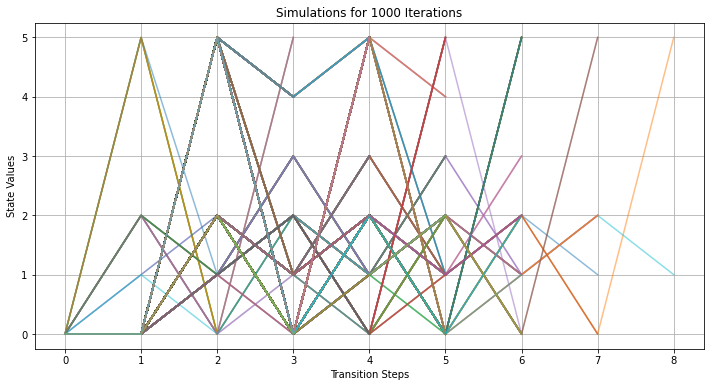

In [526]:
# Plot
plt.figure(figsize=(12, 6))

for state in all_iter_state:
    state1= [0] + state
    plt.plot(range(len(state1)), state1, alpha=0.5)

plt.title("Simulations for 1000 Iterations")
plt.xlabel("Transition Steps")
plt.ylabel("State Values")
plt.grid(True)

plt.show()


### Graph for staying at certain clusters in a year.

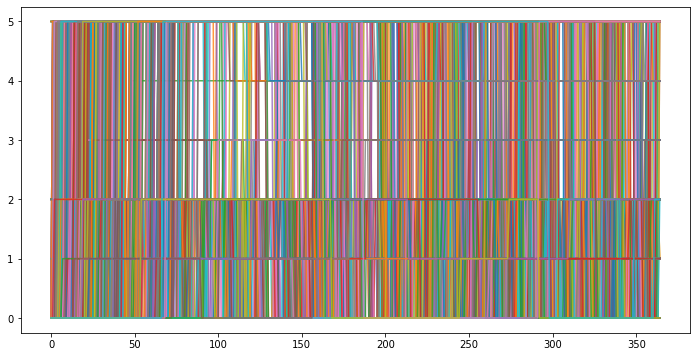

In [527]:
plt.figure(figsize=(12, 6))

# Initials
df_365= []

for sim in range(1000):
    
    plot_initial= []
    
    for j in range(len(all_iter_state[sim])):
        plot_element= []
        
        for k in range(int(all_iter_period[sim][j])):
            plot_element.append(all_iter_state[sim][j])

        plot_initial.extend(plot_element)

    # This is for below graph
    # Restrict the data to a year.
    df_365.append(plot_initial[:365])

    plt.plot(range(len(plot_initial[:365])), plot_initial[:365], alpha=0.8)
plt.show()

In [528]:
# Daily Result with 1000 simulations
total_result = pd.DataFrame(df_365).T
total_result


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,0.0
361,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,2.0
362,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,2.0
363,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,2.0


#### Split a year within certain periods(Monthly/Quaterly).
#### Seek the average probability of 'Staying at the States(clusters)' for each periods.

In [529]:
df1 = pd.DataFrame(df_365).T
df1

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,0.0
361,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,2.0
362,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,2.0
363,5.0,5.0,0.0,5.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,5.0,0.0,2.0,2.0,0.0,5.0,3.0,0.0,2.0


In [530]:
def split_data_by_period(df, split):
        """
        Split the daily data into certain periods.
        """
        df1 = pd.DataFrame(df).T

        df_list=[]
        for i in range(365):
                df_list.append(df1.iloc[i * split : (i + 1) * split])
        return df_list

In [531]:
def average_state_probability_by_periods(df, split):
    """
    This function generates the 'Average Probabilities of staying in a certain cluster' for the given split periods, respectively.
    
    The parameter "split" represents the number of days used to split a year.
    """
    
    # Initial Setting

    # Cluster Indexing; 
    # A=0,B=1,C=2,D=3,E=4,F=5
    A_average,B_average,C_average,D_average,E_average,F_average,= [],[],[],[],[],[]

    split_data=split_data_by_period(df,split)
    
    # Iterate data for each splits.
    for s in range(int(365/split)):             # s for each split. If split=30, split implies each month
        print(f"Iteration {s+1} start")
        # Each splited data before averaging
        A,B,C,D,E,F = [], [], [], [], [], []

        # Calulate Average Probability of staying in each clusters.
        for day in range(split):

            # Gather probabilities of staying in certain clusters (daily) within series.
            for state, _ in split_data[s].iloc[day,:].value_counts().items():
                
                # Probability of certain cluster in daily.
                prob  = split_data[s].iloc[day,:].value_counts(normalize=True)[state]
    
                # Split daily data with respect to each clusters.
                if state == 0:
                    A.append(prob)
                if state == 1:
                    B.append(prob)
                if state == 2:
                    C.append(prob)
                if state == 3:
                    D.append(prob)
                if state == 4:
                    E.append(prob)
                if state == 5:
                    F.append(prob)

            # If there is no assigned probability in a certain period, denote it as zero.
            if len(A) != day+1:
                A.append(0)
            if len(B) != day+1:
                B.append(0)
            if len(C) != day+1:
                C.append(0)
            if len(D) != day+1:
                D.append(0)
            if len(E) != day+1:
                E.append(0)
            if len(F) != day+1:
                F.append(0)

        # Calculate each clusters
        A_average.append(np.mean(A))
        B_average.append(np.mean(B))
        C_average.append(np.mean(C))
        D_average.append(np.mean(D))
        E_average.append(np.mean(E))
        F_average.append(np.mean(F))

    # Built it by the form of data frame.
    average_result =pd.DataFrame([A_average,B_average,C_average,D_average,E_average,F_average],
                                    columns = list(range(1,int(365/split+1)))
                                    ) 

    return average_result

In [532]:
# Weekly
average_state_probability_by_periods(df_365, 7)

Iteration 1 start
Iteration 2 start
Iteration 3 start
Iteration 4 start
Iteration 5 start
Iteration 6 start
Iteration 7 start
Iteration 8 start
Iteration 9 start
Iteration 10 start
Iteration 11 start
Iteration 12 start
Iteration 13 start
Iteration 14 start
Iteration 15 start
Iteration 16 start
Iteration 17 start
Iteration 18 start
Iteration 19 start
Iteration 20 start
Iteration 21 start
Iteration 22 start
Iteration 23 start
Iteration 24 start
Iteration 25 start
Iteration 26 start
Iteration 27 start
Iteration 28 start
Iteration 29 start
Iteration 30 start
Iteration 31 start
Iteration 32 start
Iteration 33 start
Iteration 34 start
Iteration 35 start
Iteration 36 start
Iteration 37 start
Iteration 38 start
Iteration 39 start
Iteration 40 start
Iteration 41 start
Iteration 42 start
Iteration 43 start
Iteration 44 start
Iteration 45 start
Iteration 46 start
Iteration 47 start
Iteration 48 start
Iteration 49 start
Iteration 50 start
Iteration 51 start
Iteration 52 start


,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
0,0.929286,0.796857,0.659429,0.554571,0.454571,0.375714,0.305857,0.238143,0.183571,0.139286,...,0.237000,0.242143,0.244571,0.246499,0.246103,0.238810,0.238090,0.242372,0.245880,0.249392
1,0.008714,0.024714,0.040286,0.052857,0.059143,0.065571,0.070714,0.071429,0.079143,0.092286,...,0.105000,0.103286,0.100429,0.099885,0.096525,0.096668,0.103879,0.110873,0.107752,0.099326
2,0.034429,0.086857,0.142000,0.186857,0.226571,0.263429,0.295000,0.329286,0.352714,0.363714,...,0.249571,0.255429,0.263143,0.264933,0.268268,0.270842,0.268564,0.258272,0.259779,0.261143
3,0.000000,0.000000,0.000571,0.001429,0.002000,0.002429,0.004000,0.004429,0.005429,0.006000,...,0.032571,0.031429,0.030714,0.030294,0.032890,0.032890,0.031049,0.031084,0.032240,0.035402
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000143,0.001000,0.001000,0.001000,...,0.064429,0.065714,0.067000,0.068020,0.071500,0.071071,0.068965,0.066896,0.067202,0.067794
5,0.027571,0.091571,0.157714,0.204286,0.257714,0.292857,0.324286,0.355714,0.378143,0.397714,...,0.311429,0.302000,0.294143,0.290369,0.284713,0.289718,0.289453,0.290503,0.287147,0.286943


In [533]:
# Monthly
average_state_probability_by_periods(df_365, 30)

Iteration 1 start
Iteration 2 start
Iteration 3 start
Iteration 4 start
Iteration 5 start
Iteration 6 start
Iteration 7 start
Iteration 8 start
Iteration 9 start
Iteration 10 start
Iteration 11 start
Iteration 12 start


,1,2,3,4,5,6,7,8,9,10,11,12
0,0.718567,0.314433,0.120600,0.094567,0.141367,0.216233,0.267067,0.274367,0.2571,0.247433,0.244515,0.241868
1,0.033400,0.068500,0.094200,0.105200,0.104400,0.111767,0.114000,0.125267,0.1291,0.113233,0.099832,0.104834
2,0.119300,0.292067,0.365533,0.352967,0.299367,0.233600,0.196200,0.190200,0.2088,0.232000,0.262989,0.263843
3,0.000600,0.003533,0.006000,0.009767,0.018700,0.021467,0.026633,0.029800,0.0316,0.033633,0.031411,0.032071
4,0.000000,0.000400,0.001000,0.001900,0.008967,0.018400,0.032167,0.044233,0.0526,0.061067,0.068057,0.068316
5,0.128133,0.321067,0.412667,0.435600,0.427200,0.398533,0.363933,0.336133,0.3208,0.312633,0.293195,0.289068


In [534]:
# Quaterly
average_state_probability_by_periods(df_365, 90)

Iteration 1 start
Iteration 2 start
Iteration 3 start
Iteration 4 start


,1,2,3,4
0,0.384533,0.150722,0.266178,0.244606
1,0.065367,0.107122,0.122789,0.105966
2,0.258967,0.295311,0.198400,0.252944
3,0.003378,0.016644,0.029344,0.032372
4,0.000467,0.009756,0.043000,0.065813
5,0.287289,0.420444,0.340289,0.298299


In [535]:
def plot_split_average_prob(df,mode, split):
    """
    This function is about plotting results.

    For mode, there are 4 kinds. 

    1. "bar"
        : Only bar plots
    2. "line"
        : Only line plots
    3. "bar with line"
        : Bar and line plots
    4. "bar with points"
        : Bar and points which show the values of each points.

    """
    df= average_state_probability_by_periods(df,split)
    colors = cm.Blues(range(100,600,30))

    plt.figure(figsize=(14, 7))

    if mode == 'bar' :
        ax= df.T.plot(kind=mode, figsize=(14, 7), width=0.8, color= colors)

    if mode == 'line' :
        ax= df.T.plot(kind=mode, figsize=(14, 7))
        plt.xticks(ticks=range(1,len(df.columns)+1), labels=[int(i) for i in range(1,len(df.columns)+1)])

    if mode == 'bar with line':
        ax= df.T.plot(kind="bar", figsize=(14, 7), width=0.8, color= colors)

        # Add lines for each bars
        for idx in df.index:
            plt.plot(range(len(df.columns)), df.iloc[idx], marker='o', label=f"Line {idx}")

    if mode == 'bar with points':
        ax= df.T.plot(kind="bar", figsize=(14, 7), width=0.8, color= colors)

        # Put values at the top of the bars
        for i, col in enumerate(df.columns):
            for j, v in enumerate(df[col]):
                plt.text(i + j * 0.12 - 0.3,        # Horizontal
                            v + 0.01,               # Vertical
                            f"{v:.2f}", ha='center', fontsize=9, color='black')    
    
    plt.title("Average Probability of staying in each clusters for certain periods", fontsize=16)
    plt.xlabel("Periods", fontsize=14)
    plt.xticks(rotation=0)

    plt.ylabel("Average Probability", fontsize=14)
    plt.legend(df.index, title="Cluster", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    return plt.show()
        

Iteration 1 start
Iteration 2 start
Iteration 3 start
Iteration 4 start
Iteration 5 start
Iteration 6 start
Iteration 7 start
Iteration 8 start
Iteration 9 start
Iteration 10 start
Iteration 11 start
Iteration 12 start


<Figure size 1008x504 with 0 Axes>

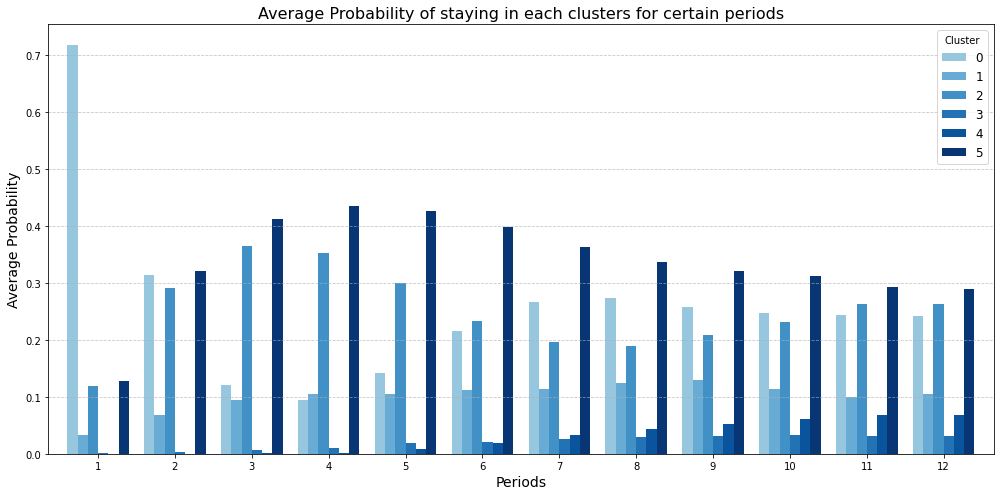

In [536]:
plot_split_average_prob(df_365,'bar', 30)

Iteration 1 start
Iteration 2 start
Iteration 3 start
Iteration 4 start
Iteration 5 start
Iteration 6 start
Iteration 7 start
Iteration 8 start
Iteration 9 start
Iteration 10 start
Iteration 11 start
Iteration 12 start
Iteration 13 start
Iteration 14 start
Iteration 15 start
Iteration 16 start
Iteration 17 start
Iteration 18 start
Iteration 19 start
Iteration 20 start
Iteration 21 start
Iteration 22 start
Iteration 23 start
Iteration 24 start
Iteration 25 start
Iteration 26 start
Iteration 27 start
Iteration 28 start
Iteration 29 start
Iteration 30 start
Iteration 31 start
Iteration 32 start
Iteration 33 start
Iteration 34 start
Iteration 35 start
Iteration 36 start
Iteration 37 start
Iteration 38 start
Iteration 39 start
Iteration 40 start
Iteration 41 start
Iteration 42 start
Iteration 43 start
Iteration 44 start
Iteration 45 start
Iteration 46 start
Iteration 47 start
Iteration 48 start
Iteration 49 start
Iteration 50 start
Iteration 51 start
Iteration 52 start
Iteration 53 start
It

<Figure size 1008x504 with 0 Axes>

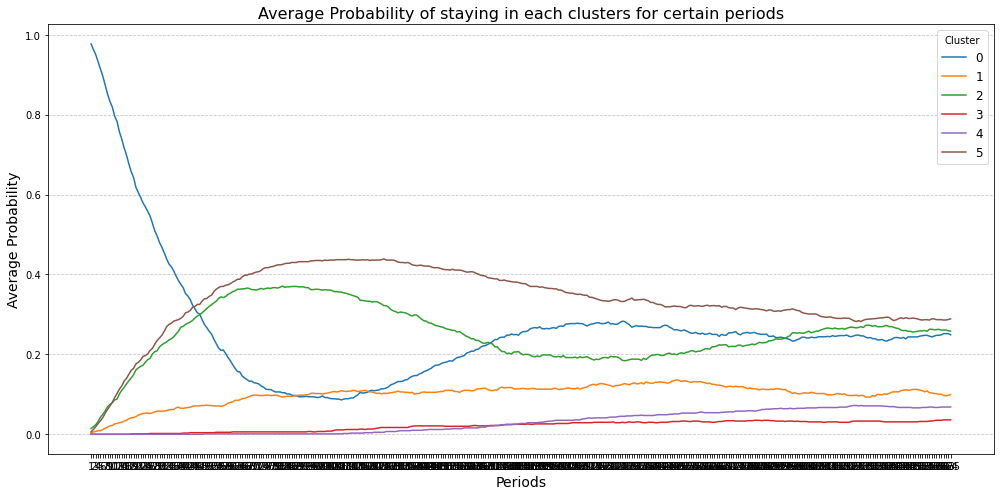

In [537]:
plot_split_average_prob(df_365,'line', 1)

Iteration 1 start
Iteration 2 start
Iteration 3 start
Iteration 4 start
Iteration 5 start
Iteration 6 start
Iteration 7 start
Iteration 8 start
Iteration 9 start
Iteration 10 start
Iteration 11 start
Iteration 12 start


<Figure size 1008x504 with 0 Axes>

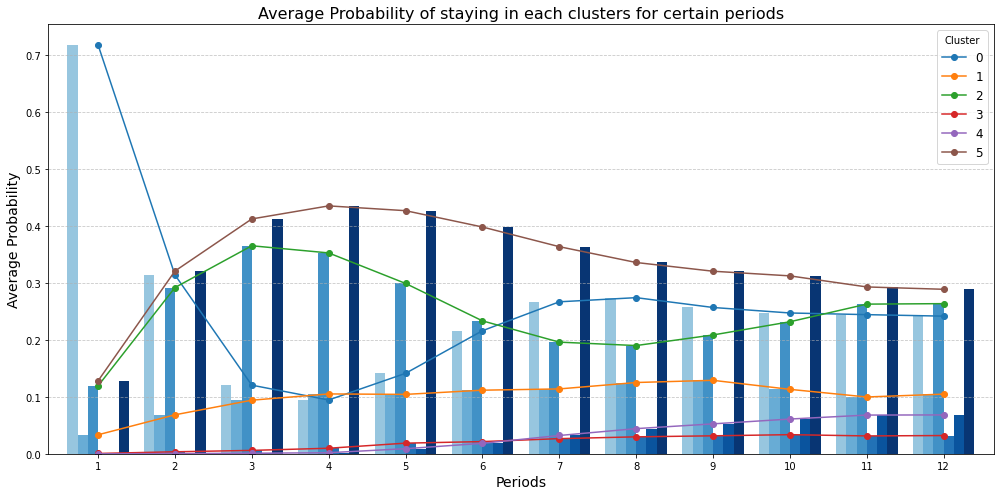

In [538]:
plot_split_average_prob(df_365,'bar with line', 30)

Iteration 1 start
Iteration 2 start
Iteration 3 start
Iteration 4 start
Iteration 5 start
Iteration 6 start
Iteration 7 start
Iteration 8 start
Iteration 9 start
Iteration 10 start
Iteration 11 start
Iteration 12 start


<Figure size 1008x504 with 0 Axes>

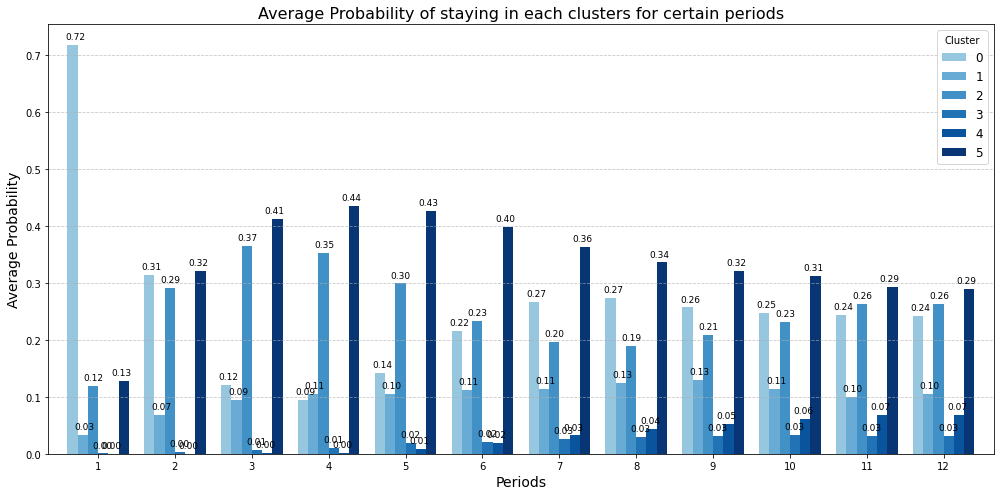

In [539]:
plot_split_average_prob(df_365,'bar with points', 30)